In [2]:
#import library

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import datetime

from keras.datasets import mnist
from keras.layers import Dense,Flatten,Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.losses import BinaryCrossentropy

In [3]:
(xTrain,yTrain),(_,_) = mnist.load_data()

In [4]:
xTrain = xTrain.reshape(xTrain.shape[0],28,28,1).astype("float32")
xTrain = (xTrain-127.5)/127.5
len(xTrain)

60000

In [5]:
batchSize = 256
trainDataset = tf.data.Dataset.from_tensor_slices(xTrain).shuffle(len(xTrain)).batch(batchSize)

In [6]:
#Dimensionality
imgRow = 28
imgCols = 28
channel = 1

imgShape = (imgRow,imgCols,channel)
zDim = 100
nepochs = 100

#graph input


In [7]:
#Generator
def buildGenerator(imgShape,zDim):
    model = Sequential()
    model.add(Dense(128,input_dim=zDim))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(28*28*1,activation="tanh"))
    model.add(Reshape(imgShape))
    return model

In [8]:
buildGenerator(imgShape,zDim).summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               12928     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               101136    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 114,064
Trainable params: 114,064
Non-trainable params: 0
_________________________________________________________________


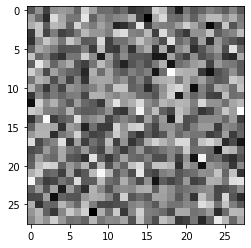

In [9]:
generator = buildGenerator(imgShape,zDim)

noise = tf.random.normal([1,zDim])
genImg = generator(noise,training = False)

plt.imshow(genImg[0,:,:,0],cmap="gray")

In [10]:
#Discriminator
def buildDiscriminator(imgShape):
    model= Sequential()
    model.add(Flatten(input_shape=imgShape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1,activation="sigmoid"))
    return model

In [11]:
buildDiscriminator(imgShape).summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________


In [12]:
discriminator = buildDiscriminator(imgShape)
decision = discriminator(genImg, training= False)

print(decision)

tf.Tensor([[0.5433644]], shape=(1, 1), dtype=float32)


In [13]:
crossentropy = BinaryCrossentropy(from_logits=False)

In [14]:
def dLoss(real,fake):
    realLoss = crossentropy(tf.ones_like(real),real)
    fakeLoss = crossentropy(tf.zeros_like(fake), fake)
    return realLoss+fakeLoss
    

In [15]:
def gLoss(fake):
    return crossentropy(tf.ones_like(fake),fake)

In [16]:
generatorOpitmiser = tf.keras.optimizers.Adam()
discriminatorOptimiser = tf.keras.optimizers.Adam()

In [17]:
d_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
d_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
g_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)


In [23]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batchSize, zDim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      genImg = generator(noise, training=True)

      real = discriminator(images, training=True)
      fake = discriminator(genImg, training=True)

      genLoss = gLoss(fake)
      disLoss = dLoss(real, fake)
      
    gradientsOfGenerator = gen_tape.gradient(genLoss, generator.trainable_variables)
    gradientsOfDiscriminator = disc_tape.gradient(disLoss, discriminator.trainable_variables)

    generatorOpitmiser.apply_gradients(zip(gradientsOfGenerator, generator.trainable_variables))
    discriminatorOptimiser.apply_gradients(zip(gradientsOfDiscriminator, discriminator.trainable_variables))

    d_loss(disLoss)
    g_loss(genLoss)
    acc = tf.reduce_mean(100-100*discriminator(genImg,training=False))
    return genLoss,disLoss,acc

In [24]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
gan_log_dir = 'logs/gradient_tape/' + current_time + '/test'
gan_summary_writer = tf.summary.create_file_writer(gan_log_dir)


In [25]:
def training(dataset,nepochs,sampleInterval):
    for epoch in range(nepochs):
      start = time.time()

      for batch in dataset:
        train_step(batch)
        genLoss,disLoss,acc = train_step(batch)

        with gan_summary_writer.as_default():
          tf.summary.scalar('loss', d_loss.result(), step=epoch)
          tf.summary.scalar('loss', g_loss.result(), step=epoch)
          tf.summary.scalar('accuracy', d_accuracy.result(), step=epoch)
        
      if (epoch + 1) % sampleInterval ==0:
        print ('Time for epoch {} is {} sec'.format(epoch + 1, np.round(time.time()-start)))
        print("Epoch: ",epoch + 1,"| Discriminator Loss: ",np.round(tf.get_static_value(disLoss),2),"| Accuracy: ",np.round(tf.get_static_value(acc),2),"%","| Generator Loss: ",np.round(tf.get_static_value(genLoss),2))
        print("---------------------------------------------------------------------------------------------------------------------------------------------------------------")
        sampleImg(generator)

In [26]:
def sampleImg(generator,imgGridRow = 4, imgGridColumn = 4):
    #noise = np.random.normal(0,1,(imgGridRow*imgGridColumn,zDim))
    noise = tf.random.normal([batchSize, zDim])
    genImg = generator.predict(noise)
    genImg = 127.5*genImg+127.5

    fig, axs = plt.subplots(imgGridRow,imgGridColumn,figsize=(4,4),sharey = True,sharex=True)
    cnt = 0
    for i in range(imgGridRow):
        for j in range(imgGridColumn):
            axs[i,j].imshow(genImg[cnt,:,:,0],cmap="gray")
            axs[i,j].axis("off")
            cnt+=1
    plt.show()

Time for epoch 5 is 2.0 sec
Epoch:  5 | Discriminator Loss:  2.11 | Accuracy:  48.41 % | Generator Loss:  0.75
---------------------------------------------------------------------------------------------------------------------------------------------------------------


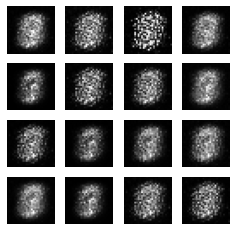

Time for epoch 10 is 2.0 sec
Epoch:  10 | Discriminator Loss:  2.14 | Accuracy:  59.37 % | Generator Loss:  0.91
---------------------------------------------------------------------------------------------------------------------------------------------------------------


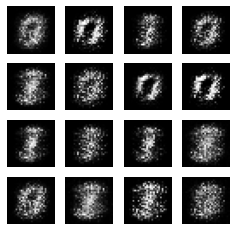

Time for epoch 15 is 2.0 sec
Epoch:  15 | Discriminator Loss:  1.42 | Accuracy:  68.09 % | Generator Loss:  1.2
---------------------------------------------------------------------------------------------------------------------------------------------------------------


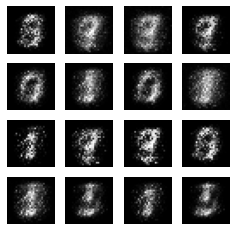

Time for epoch 20 is 2.0 sec
Epoch:  20 | Discriminator Loss:  0.7 | Accuracy:  91.63 % | Generator Loss:  3.74
---------------------------------------------------------------------------------------------------------------------------------------------------------------


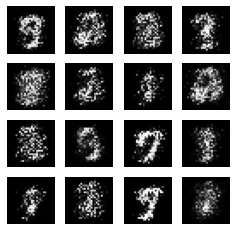

Time for epoch 25 is 2.0 sec
Epoch:  25 | Discriminator Loss:  0.95 | Accuracy:  86.71 % | Generator Loss:  2.72
---------------------------------------------------------------------------------------------------------------------------------------------------------------


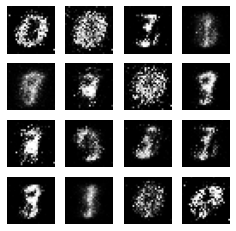

Time for epoch 30 is 2.0 sec
Epoch:  30 | Discriminator Loss:  0.92 | Accuracy:  74.19 % | Generator Loss:  2.01
---------------------------------------------------------------------------------------------------------------------------------------------------------------


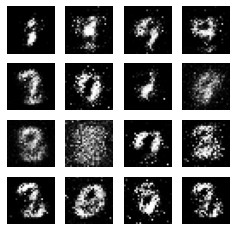

Time for epoch 35 is 2.0 sec
Epoch:  35 | Discriminator Loss:  1.07 | Accuracy:  76.61 % | Generator Loss:  2.04
---------------------------------------------------------------------------------------------------------------------------------------------------------------


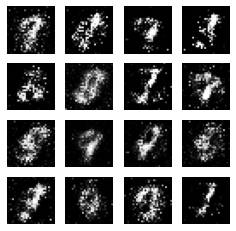

Time for epoch 40 is 2.0 sec
Epoch:  40 | Discriminator Loss:  0.64 | Accuracy:  84.86 % | Generator Loss:  2.25
---------------------------------------------------------------------------------------------------------------------------------------------------------------


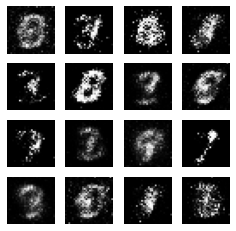

Time for epoch 45 is 2.0 sec
Epoch:  45 | Discriminator Loss:  1.18 | Accuracy:  71.05 % | Generator Loss:  2.12
---------------------------------------------------------------------------------------------------------------------------------------------------------------


Time for epoch 50 is 2.0 sec
Epoch:  50 | Discriminator Loss:  0.93 | Accuracy:  80.54 % | Generator Loss:  1.67
---------------------------------------------------------------------------------------------------------------------------------------------------------------


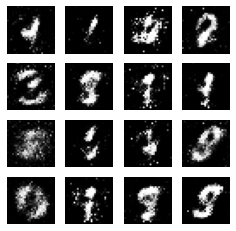

Time for epoch 55 is 2.0 sec
Epoch:  55 | Discriminator Loss:  0.81 | Accuracy:  83.82 % | Generator Loss:  2.82
---------------------------------------------------------------------------------------------------------------------------------------------------------------


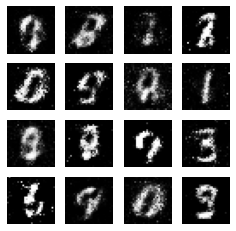

Time for epoch 60 is 2.0 sec
Epoch:  60 | Discriminator Loss:  1.25 | Accuracy:  71.43 % | Generator Loss:  1.48
---------------------------------------------------------------------------------------------------------------------------------------------------------------


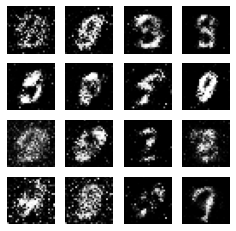

Time for epoch 65 is 2.0 sec
Epoch:  65 | Discriminator Loss:  1.08 | Accuracy:  72.8 % | Generator Loss:  1.55
---------------------------------------------------------------------------------------------------------------------------------------------------------------


Time for epoch 70 is 2.0 sec
Epoch:  70 | Discriminator Loss:  1.16 | Accuracy:  73.97 % | Generator Loss:  1.69
---------------------------------------------------------------------------------------------------------------------------------------------------------------


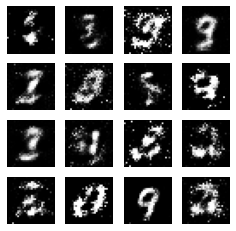

Time for epoch 75 is 2.0 sec
Epoch:  75 | Discriminator Loss:  0.99 | Accuracy:  69.1 % | Generator Loss:  1.68
---------------------------------------------------------------------------------------------------------------------------------------------------------------


Time for epoch 80 is 2.0 sec
Epoch:  80 | Discriminator Loss:  1.05 | Accuracy:  76.86 % | Generator Loss:  1.7
---------------------------------------------------------------------------------------------------------------------------------------------------------------


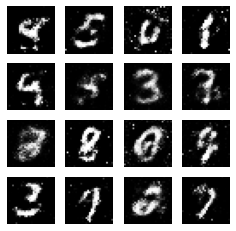

Time for epoch 85 is 2.0 sec
Epoch:  85 | Discriminator Loss:  0.86 | Accuracy:  76.01 % | Generator Loss:  1.73
---------------------------------------------------------------------------------------------------------------------------------------------------------------


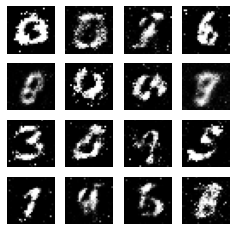

Time for epoch 90 is 2.0 sec
Epoch:  90 | Discriminator Loss:  1.1 | Accuracy:  70.95 % | Generator Loss:  1.49
---------------------------------------------------------------------------------------------------------------------------------------------------------------


Time for epoch 95 is 2.0 sec
Epoch:  95 | Discriminator Loss:  1.28 | Accuracy:  67.71 % | Generator Loss:  1.44
---------------------------------------------------------------------------------------------------------------------------------------------------------------


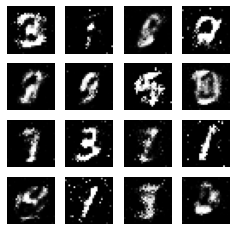

Time for epoch 100 is 2.0 sec
Epoch:  100 | Discriminator Loss:  0.69 | Accuracy:  82.44 % | Generator Loss:  2.11
---------------------------------------------------------------------------------------------------------------------------------------------------------------


In [27]:
#activate hyperparameters
sampleInterval = 5
training(trainDataset, nepochs,sampleInterval)

In [ ]:
import tensorboard